In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency, fisher_exact, gaussian_kde, ks_2samp,wasserstein_distance,pearsonr,variation,zscore
from sklearn.metrics import mutual_info_score
#from skimage.metrics import structural_similarity as ssim
from statsmodels.stats.proportion import proportions_ztest


### VALIDATE HDBSCAN (between intra and inter cluster distances)

In [2]:
def calculate_distances(umap_space, medoid_indices, cluster_sampling_indices, n_samples=50):
    """
    Calculate average distances within and across clusters based on medoid points.

    Parameters:
    - umap_space: ndarray, shape (n_frames, n_features)
        The high-dimensional feature space (e.g., UMAP output).
    - medoid_indices: ndarray, shape (n_clusters,)
        Indices of medoid points for each cluster.
    - cluster_sampling_indices: ndarray, shape (n_clusters, n_samples)
        Indices of sampled points closest to the medoid for each cluster.
    - n_samples: int
        Number of points to sample per cluster.

    Returns:
    - intra_cluster_distances: list of float
        Average distances between medoid and sampled points within each cluster.
    - inter_cluster_distances: list of float
        Average distances between each medoid and sampled points from all other clusters.
    """
    n_clusters = len(medoid_indices)
    intra_cluster_distances = []
    inter_cluster_distances = []
    
    # Loop over each cluster
    for cluster_idx in range(n_clusters):
        medoid_idx = medoid_indices[cluster_idx]
        medoid_point = umap_space[medoid_idx]

        # Intra-cluster distances
        sampled_indices = cluster_sampling_indices[cluster_idx, :n_samples]
        sampled_points = umap_space[sampled_indices]
        intra_distances = cdist([medoid_point], sampled_points).mean()
        intra_cluster_distances.append(intra_distances)

        # Inter-cluster distances
        other_clusters_indices = [
            cluster_sampling_indices[other_idx, :n_samples].flatten()
            for other_idx in range(n_clusters) if other_idx != cluster_idx
        ]
        other_clusters_indices = np.concatenate(other_clusters_indices)
        other_points = umap_space[other_clusters_indices]
        inter_distances = cdist([medoid_point], other_points).mean()
        inter_cluster_distances.append(inter_distances)

    return intra_cluster_distances, inter_cluster_distances


In [3]:
def plot_cluster_distances(intra_distances, inter_distances):
    n_clusters = len(intra_distances)
    x = np.arange(n_clusters)

    plt.figure(figsize=(12, 6))
    bar_width = 0.35

    # Plot intra-cluster distances
    plt.bar(x - bar_width / 2, intra_distances, width=bar_width, label='Intra-cluster Distance', color='blue', alpha=0.7)

    # Plot inter-cluster distances
    plt.bar(x + bar_width / 2, inter_distances, width=bar_width, label='Inter-cluster Distance', color='orange', alpha=0.7)

    # Add labels and legend
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Average Distance', fontsize=14)
    
    plt.title('Cluster Validation: Intra vs. Inter Distances', fontsize=16)
    plt.xticks(x, [f'Cluster {i+1}' for i in x], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

def log_transform_and_plot(intra_distances, inter_distances):
    # 리스트를 numpy 배열로 변환
    intra_distances = np.array(intra_distances)
    inter_distances = np.array(inter_distances)
    
    # 로그 변환 (0을 방지하기 위해 epsilon 추가)
    epsilon = 1 # 로그 변환 시 0 방지
    log_intra = np.log(intra_distances + epsilon)
    log_inter = np.log(inter_distances + epsilon)

    # 플롯
    n_clusters = len(intra_distances)
    x = np.arange(n_clusters)
    bar_width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - bar_width / 2, log_intra, width=bar_width, label='Log-transformed Intra-cluster Distance', color='blue', alpha=0.7)
    plt.bar(x + bar_width / 2, log_inter, width=bar_width, label='Log-transformed Inter-cluster Distance', color='orange', alpha=0.7)

    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Log-transformed Distance', fontsize=14)
    plt.title('Log-transformed Intra vs. Inter Distances', fontsize=16)
    plt.xticks(x, [f'Cluster {i+1}' for i in x], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [24]:
def normalize_combined_data(intra_distances, inter_distances):
    """Normalize both intra and inter distances together using their combined min and max."""
    all_distances = np.concatenate([intra_distances, inter_distances])  # Combine both arrays
    min_val = np.min(all_distances)
    max_val = np.max(all_distances)
    normalized_intra = (intra_distances - min_val) / (max_val - min_val + 1e-10)  # Prevent division by zero
    normalized_inter = (inter_distances - min_val) / (max_val - min_val + 1e-10)
    return normalized_intra, normalized_inter

def plot_normalized_cluster_distances(intra_distances, inter_distances):
    # Normalize both intra and inter distances together
    normalized_intra, normalized_inter = normalize_combined_data(intra_distances, inter_distances)

    # Plot normalized distances
    n_clusters = len(intra_distances)
    x = np.arange(n_clusters)
    bar_width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - bar_width / 2, normalized_intra, width=bar_width, label='Intra-cluster Distance', color='blue', alpha=0.7)
    plt.bar(x + bar_width / 2, normalized_inter, width=bar_width, label='Inter-cluster Distance', color='orange', alpha=0.7)

    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Normalized Distance (0 to 1)', fontsize=14)
    plt.title('Intra vs. Inter Distances', fontsize=16)
    plt.xticks(x, [f'Cluster {i+1}' for i in x], rotation=45)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

def log_transform_and_normalize_and_plot(intra_distances, inter_distances):
    # Convert to numpy arrays
    intra_distances = np.array(intra_distances)
    inter_distances = np.array(inter_distances)
    
    # Log transform (add epsilon to avoid log(0))
    epsilon = 1
    log_intra = np.log(intra_distances + epsilon)
    log_inter = np.log(inter_distances + epsilon)
    
    # Normalize log-transformed data together
    normalized_log_intra, normalized_log_inter = normalize_combined_data(log_intra, log_inter)

    # Plot
    n_clusters = len(intra_distances)
    x = np.arange(n_clusters)
    bar_width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - bar_width / 2, normalized_log_intra, width=bar_width, label='Intra-cluster Distance(Log-transformed)', color='blue', alpha=0.7)
    plt.bar(x + bar_width / 2, normalized_log_inter, width=bar_width, label='Inter-cluster Distance(Log-transformed)', color='orange', alpha=0.7)

    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Normalized Distance (0 to 1, log)', fontsize=14)
    plt.title('Intra vs. Inter Distances', fontsize=16)
    plt.xticks(x, [f'Cluster {i+1}' for i in x], rotation=45)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


### ANAYLZE CLUSTER DIFFERENCE BEWTEEN GROUPS

##### Proportion and KDE Analysis

In [4]:
def analyze_cluster_differences(data, cluster_labels, kde_threshold=0.01):
    """
    Analyze differences between groups for each cluster. Groups are automatically 
    created by splitting the dataset into two halves: Group 1 is the first half, 
    Group 2 is the second half.
    
    Args:
        data (ndarray): Nx2 array of data points.
        cluster_labels (ndarray): Cluster labels from a clustering algorithm (e.g., HDBSCAN).
        kde_threshold (float): Threshold to filter KDE density values.
    
    Returns:
        dict: Results containing statistical test outcomes for both proportion and KDE-based comparisons.
    """
    results = {}
    n_samples = len(data)
    mid_idx = n_samples // 2  # 데이터셋 절반으로 나누기

    # 그룹 레이블 생성: 첫 번째 절반은 그룹 1, 두 번째 절반은 그룹 2
    group_labels = np.zeros(n_samples)
    group_labels[mid_idx:] = 1  # 두 번째 절반을 그룹 2로

    unique_clusters = np.unique(cluster_labels[cluster_labels != -1])  # Exclude noise (-1)

    # Total counts for each group (outside the loop for proportion comparison)
    total_group_0 = np.sum(group_labels == 0)
    total_group_1 = np.sum(group_labels == 1)

    for cluster_id in unique_clusters:
        # Mask for the current cluster
        cluster_mask = cluster_labels == cluster_id

        # Group-wise counts in the cluster
        group_0_count = np.sum(cluster_mask & (group_labels == 0))
        group_1_count = np.sum(cluster_mask & (group_labels == 1))

        # Step 1: Proportion analysis - compare likelihood of being in the cluster
        # Normalize by total group counts
        group_0_rate = group_0_count / total_group_0
        group_1_rate = group_1_count / total_group_1

        # Proportion Z-Test (if both groups have sufficient counts)
        z_stat, p_value = None, None
        if total_group_0 > 0 and total_group_1 > 0:
            z_stat, p_value = proportions_ztest([group_0_count, group_1_count],
                                                [total_group_0, total_group_1])

        # Step 2: KDE-based spatial distribution analysis
        cluster_data_0 = data[cluster_mask & (group_labels == 0)]
        cluster_data_1 = data[cluster_mask & (group_labels == 1)]

        kde_result = None
        if len(cluster_data_0) > 1 and len(cluster_data_1) > 1:
            kde_0 = gaussian_kde(cluster_data_0.T)
            kde_1 = gaussian_kde(cluster_data_1.T)

            # Generate a grid for evaluation
            x_min, x_max = np.min(data[:, 0]), np.max(data[:, 0])
            y_min, y_max = np.min(data[:, 1]), np.max(data[:, 1])
            x_grid, y_grid = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
            positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

            # Evaluate KDE on the grid
            kde_0_values = kde_0(positions)
            kde_1_values = kde_1(positions)

            # Apply threshold
            kde_0_values[kde_0_values < kde_threshold] = 0
            kde_1_values[kde_1_values < kde_threshold] = 0

            # Wasserstein Distance
            wasserstein_dist = wasserstein_distance(kde_0_values, kde_1_values)

            # Kolmogorov-Smirnov Test
            ks_stat, ks_p = ks_2samp(kde_0_values, kde_1_values)

            kde_result = {
                "wasserstein_distance": wasserstein_dist,
                "ks_stat": ks_stat,
                "ks_p": ks_p,
            }

        # Save results for the cluster
        results[cluster_id] = {
            "proportion_analysis": {
                "group_0_rate": group_0_rate,
                "group_1_rate": group_1_rate,
                "z_stat": z_stat,
                "p_value": p_value,
            },
            "kde_analysis": kde_result,
            "counts": {
                "group_0_count": group_0_count,
                "group_1_count": group_1_count,
            },
        }

    return results


##### SPAEF analysis

In [14]:
def filter_nan(s,o):
    data = np.transpose(np.array([s.flatten(),o.flatten()]))
    data = data[~np.isnan(data).any(1)]
    return data[:,0], data[:,1]

def SPAEF(s, o):
    #remove NANs    
    s,o = filter_nan(s,o)

    bins=int(np.around(math.sqrt(len(o)),0))

    #compute corr coeff
    alpha = np.corrcoef(s,o)[0,1]
    #compute ratio of CV
    beta = variation(s)/variation(o)
    #compute zscore mean=0, std=1
    o=zscore(o)
    s=zscore(s)
    #compute histograms
    hobs,binobs = np.histogram(o,bins)
    hsim,binsim = np.histogram(s,bins)
    #convert int to float, critical conversion for the result
    hobs=np.float64(hobs)
    hsim=np.float64(hsim)
    #find the overlapping of two histogram      
    minima = np.minimum(hsim, hobs)
    #compute the fraction of intersection area to the observed histogram area, hist intersection/overlap index   
    gamma = np.sum(minima)/np.sum(hobs)
    #compute SPAEF finally with three vital components
    spaef = 1- np.sqrt( (alpha-1)**2 + (beta-1)**2 + (gamma-1)**2 )  
    print(f"SPAEF: {spaef:.4f}")
    print(f'Pearson Corr: {alpha:.4f}')
    print(f'Spatial variability: {beta:.4f}')
    print(f'Histogram: {gamma:.4f}')
    return spaef, alpha, beta, gamma


In [15]:
def visualize_two_group(matrix1, matrix2, interpolation = None, vmin=None, vmax = None):
    # 행렬 시각화
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(matrix1, origin='lower', cmap='cividis', interpolation=interpolation, vmin=vmin, vmax=vmax)
    plt.colorbar(label='Density')
    plt.title('Matrix1')
    plt.subplot(1, 2, 2)
    plt.imshow(matrix2, origin='lower', cmap='cividis', interpolation=interpolation, vmin=vmin, vmax=vmax)
    plt.colorbar(label='Density')
    plt.title('Matrix2')
    plt.tight_layout()
    plt.show()

    # 히스토그램 비교
    plt.figure(figsize=(6, 3))

    # Matrix1 히스토그램
    hist1, edges1 = np.histogram(matrix1.flatten(), bins=len(matrix1), density=True)
    bin_width1 = edges1[1] - edges1[0]  # bin의 너비
    plt.bar(edges1[:-1], hist1, width=bin_width1, alpha=0.5, color='blue', label='Matrix1')

    # Matrix2 히스토그램
    hist2, edges2 = np.histogram(matrix2.flatten(), bins=len(matrix2), density=True)
    bin_width2 = edges2[1] - edges2[0]  # bin의 너비
    plt.bar(edges2[:-1], hist2, width=bin_width2, alpha=0.5, color='red', label='Matrix2')

    # 선 그래프도 추가
    plt.plot(edges1[:-1] + bin_width1 / 2, hist1, color='blue', linestyle='-', linewidth=2)
    plt.plot(edges2[:-1] + bin_width2 / 2, hist2, color='red', linestyle='-', linewidth=2)

    # 그래프 설정
    plt.legend()
    plt.title('Histogram Comparison')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [20]:
def filter_non_zero_equal(s, o):
    # 두 그룹에서 0이 같은 위치에서만 제외
    valid_mask = (s != 0) & (o != 0)  # 두 그룹 모두에서 0이 아닌 값만 선택
    s_filtered = s[valid_mask]
    o_filtered = o[valid_mask]
    print(f'length:{len(s_filtered)}')
    return s_filtered, o_filtered

def SPAEF_nonzero(s, o):
    # 0 값을 제외한 데이터만 필터링
    s, o = filter_non_zero_equal(s, o)

    bins = int(np.around(math.sqrt(len(o)), 0))

    # corr coefficient 계산
    alpha = np.corrcoef(s, o)[0, 1]
    # CV 비율 계산
    beta = variation(s) / variation(o)
    # Z-score 계산
    o = zscore(o)
    s = zscore(s)
    # 히스토그램 계산
    hobs, binobs = np.histogram(o, bins)
    hsim, binsim = np.histogram(s, bins)
    
    # 히스토그램을 float로 변환
    hobs = np.float64(hobs)
    hsim = np.float64(hsim)
    # 두 히스토그램의 교차 부분 계산
    minima = np.minimum(hsim, hobs)
    # 히스토그램 교차 영역 비율 계산
    gamma = np.sum(minima) / np.sum(hobs)
    # SPAEF 계산
    spaef = 1 - np.sqrt((alpha - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)
    print(f"SPAEF: {spaef:.4f}")
    print(f'Pearson Corr: {alpha:.4f}')
    print(f'Spatial variability: {beta:.4f}')
    print(f'Histogram: {gamma:.4f}')
    return spaef, alpha, beta, gamma


### COMMAND

##### validation w/ distances

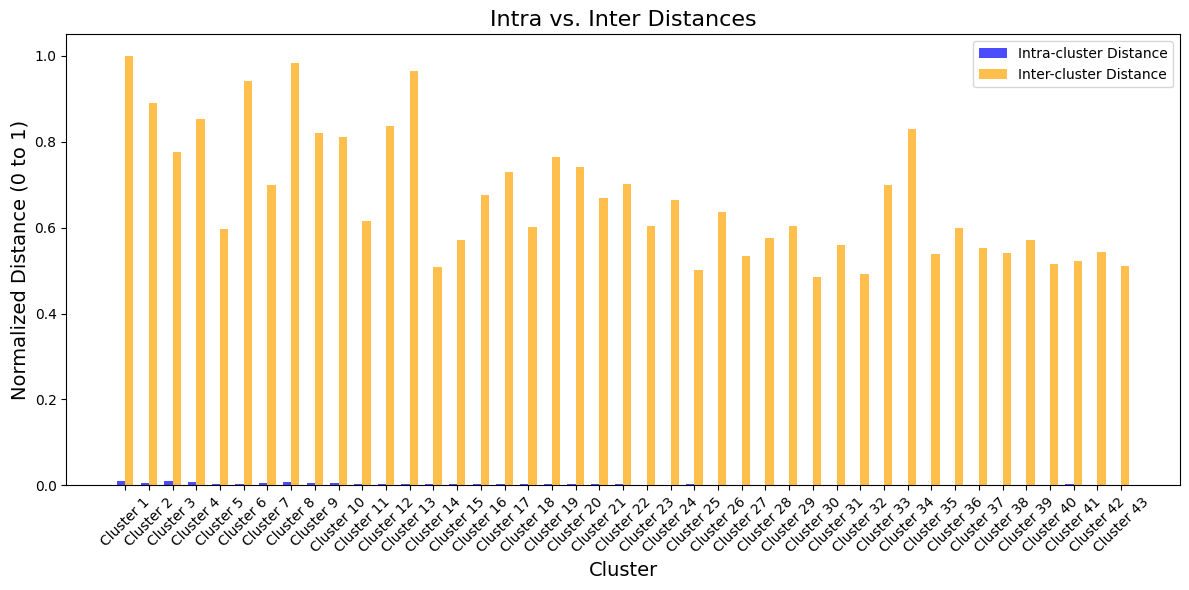

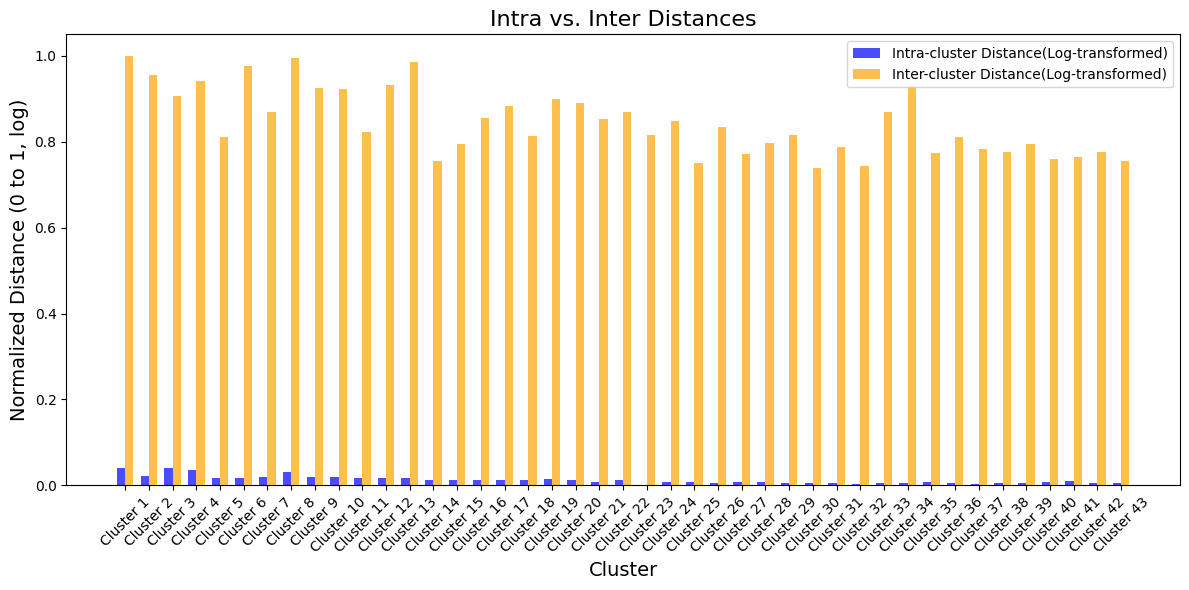

In [25]:
umap_space = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/umap/umap_space_40_0.1_eu.npy')
medoid_indices = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/medoid/medoid_indices_500.npy')
cluster_sampling_indices = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/medoid/cluster_sampling_indices_500.npy')
n_samples = 100

intra_cluster_distances, inter_cluster_distances = calculate_distances(umap_space, medoid_indices, cluster_sampling_indices, n_samples)
# plot_cluster_distances(intra_cluster_distances, inter_cluster_distances)
# log_transform_and_plot(intra_cluster_distances, inter_cluster_distances)
plot_normalized_cluster_distances(intra_cluster_distances, inter_cluster_distances)
log_transform_and_normalize_and_plot(intra_cluster_distances, inter_cluster_distances)

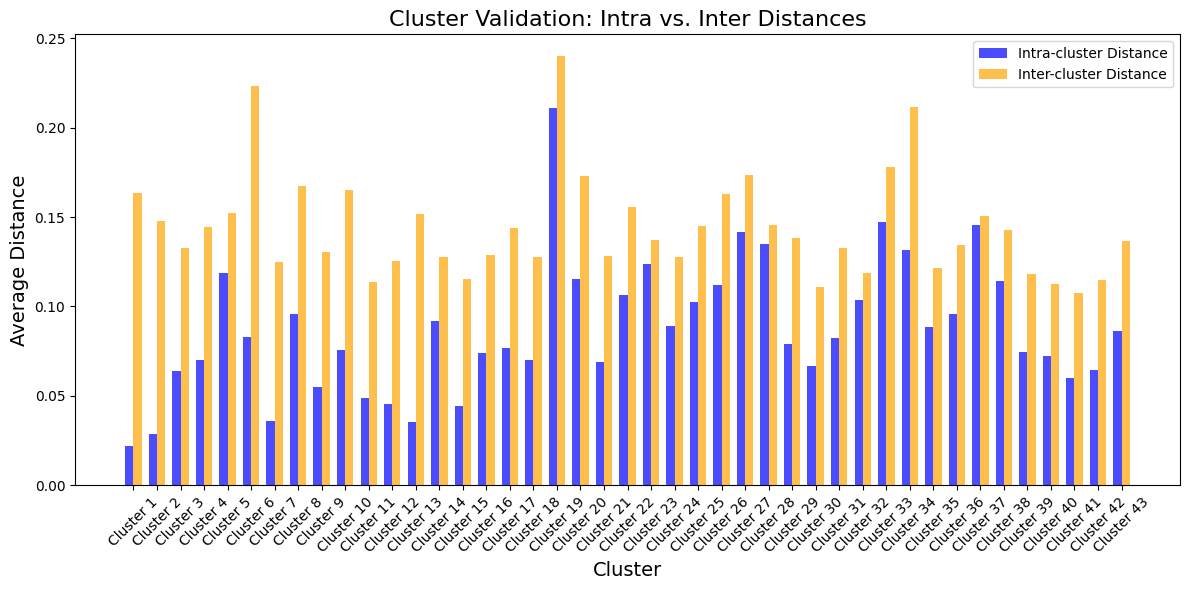

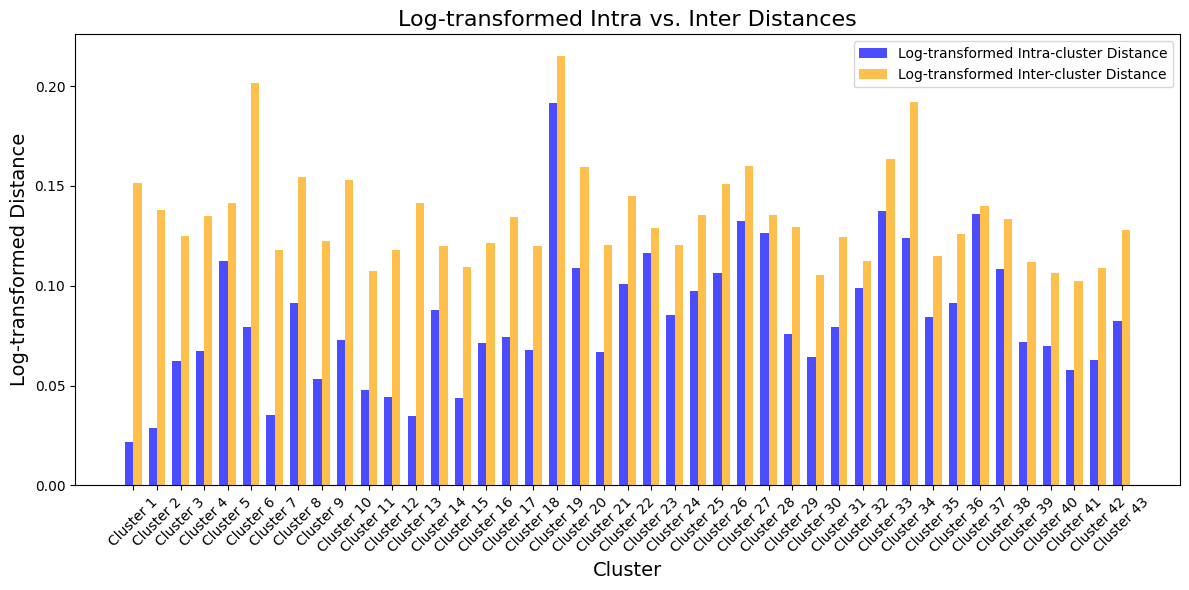

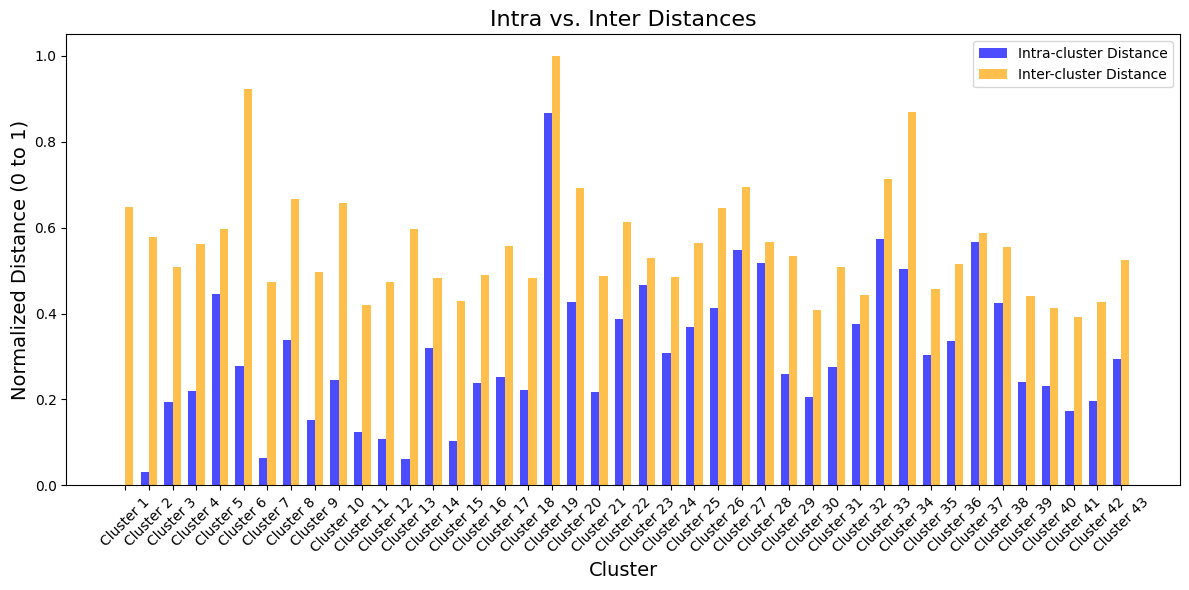

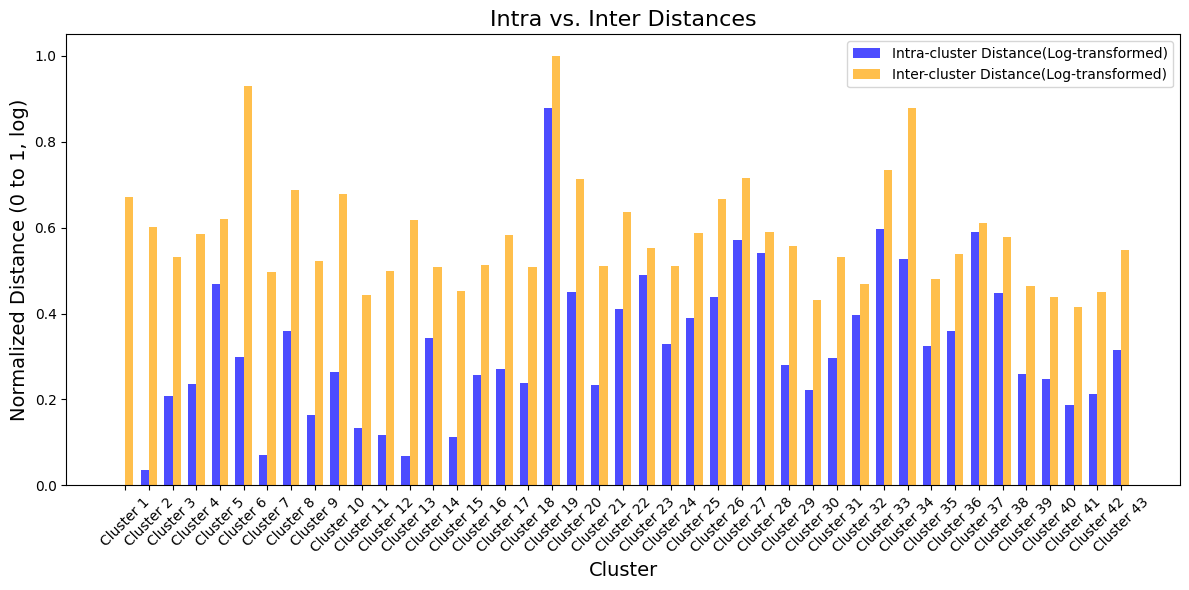

In [30]:
vae_space = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/vae_latentspace.npy')
medoid_indices = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/medoid/medoid_indices_500.npy')
cluster_sampling_indices = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/medoid/cluster_sampling_indices_500.npy')
n_samples = 100

intra_cluster_distances, inter_cluster_distances = calculate_distances(vae_space, medoid_indices, cluster_sampling_indices, n_samples)
plot_cluster_distances(intra_cluster_distances, inter_cluster_distances)
log_transform_and_plot(intra_cluster_distances, inter_cluster_distances)
plot_normalized_cluster_distances(intra_cluster_distances, inter_cluster_distances)
log_transform_and_normalize_and_plot(intra_cluster_distances, inter_cluster_distances)

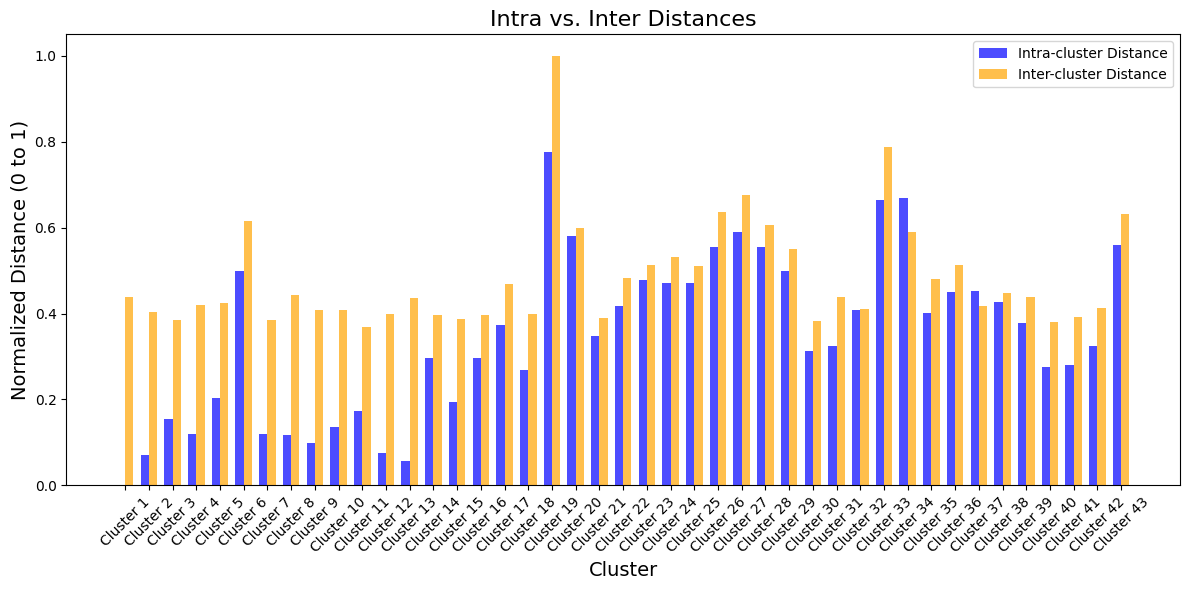

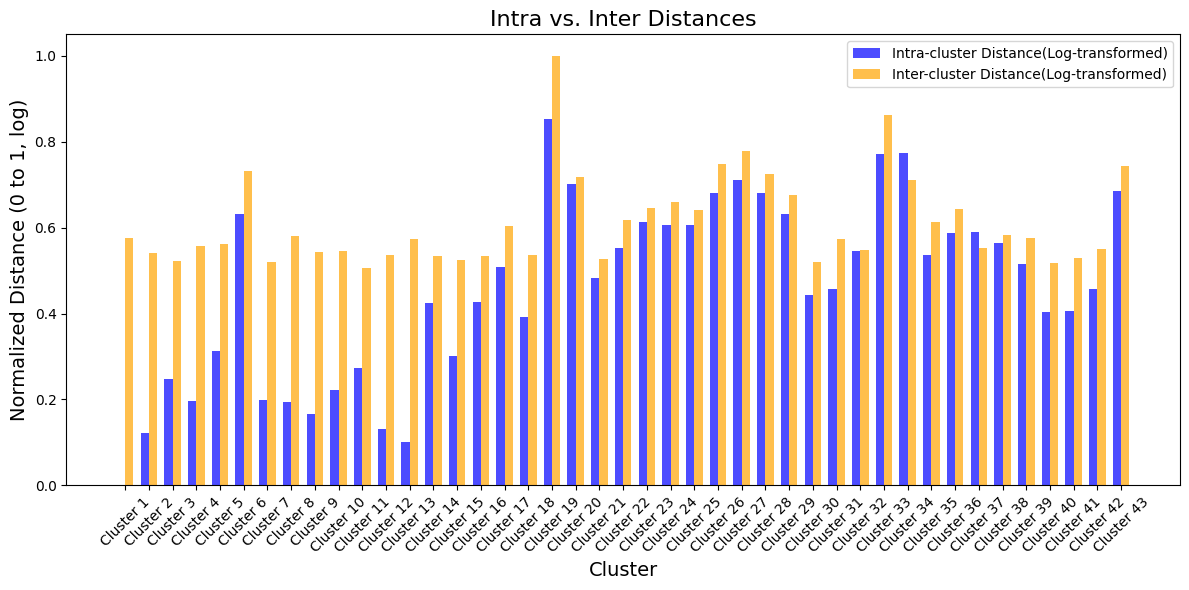

In [27]:
cwt_space = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/cwt/cwt_1_20_1_amp_reshaped_filter.npy')
medoid_indices = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/medoid/medoid_indices_500.npy')
cluster_sampling_indices = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/medoid/cluster_sampling_indices_500.npy')
n_samples = 100

intra_cluster_distances, inter_cluster_distances = calculate_distances(cwt_space.T, medoid_indices, cluster_sampling_indices, n_samples)
# plot_cluster_distances(intra_cluster_distances, inter_cluster_distances)
# log_transform_and_plot(intra_cluster_distances, inter_cluster_distances)
plot_normalized_cluster_distances(intra_cluster_distances, inter_cluster_distances)
log_transform_and_normalize_and_plot(intra_cluster_distances, inter_cluster_distances)

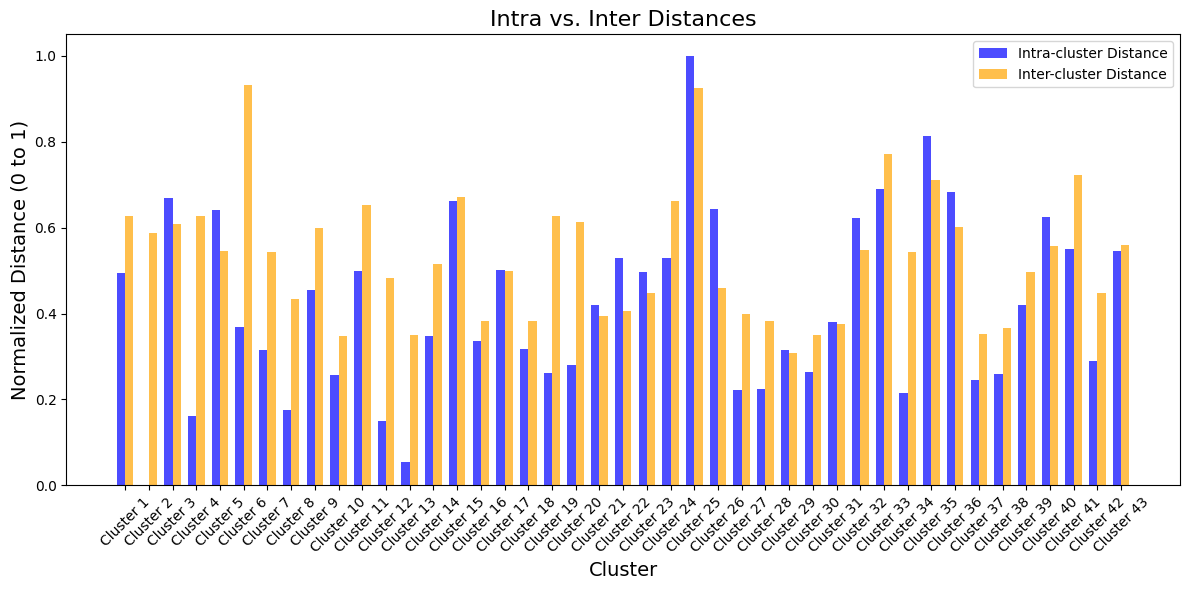

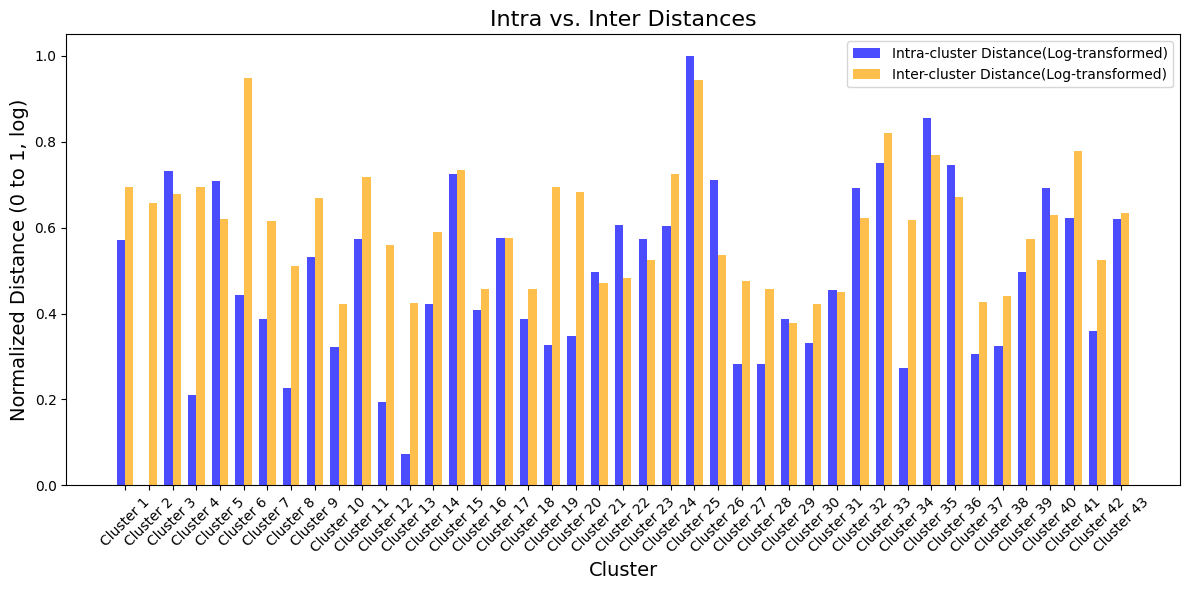

In [28]:
preprocess_space = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/preprocess_True_True_True_True.npy')
medoid_indices = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/medoid/medoid_indices_500.npy')
cluster_sampling_indices = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/medoid/cluster_sampling_indices_500.npy')
n_samples = 100

intra_cluster_distances, inter_cluster_distances = calculate_distances(preprocess_space, medoid_indices, cluster_sampling_indices, n_samples)
# plot_cluster_distances(intra_cluster_distances, inter_cluster_distances)
# log_transform_and_plot(intra_cluster_distances, inter_cluster_distances)
plot_normalized_cluster_distances(intra_cluster_distances, inter_cluster_distances)
log_transform_and_normalize_and_plot(intra_cluster_distances, inter_cluster_distances)

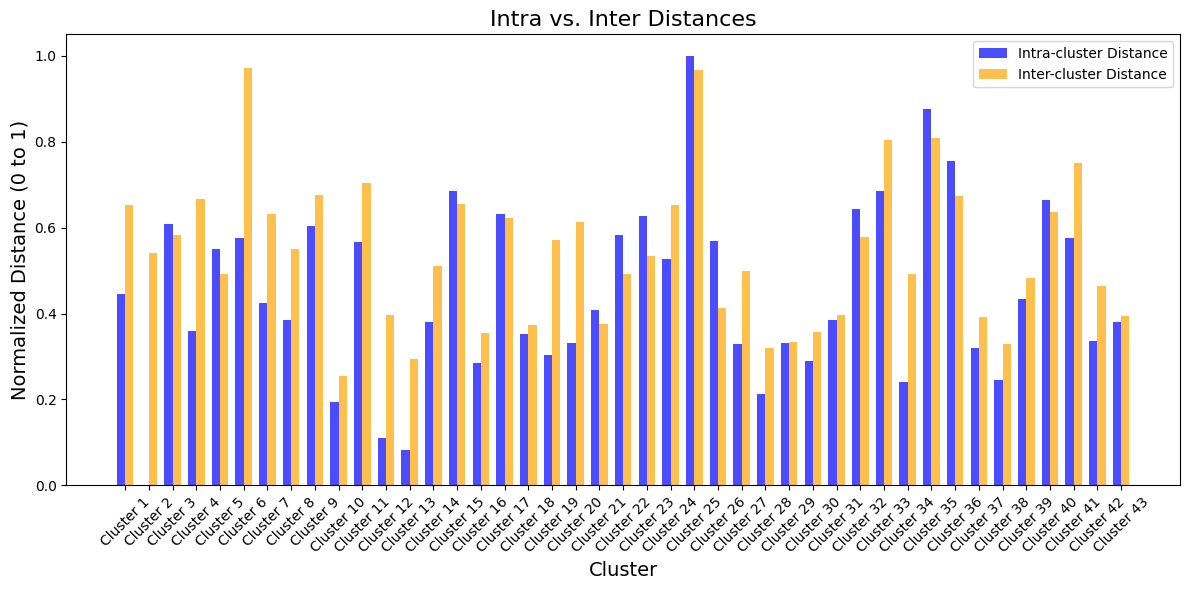

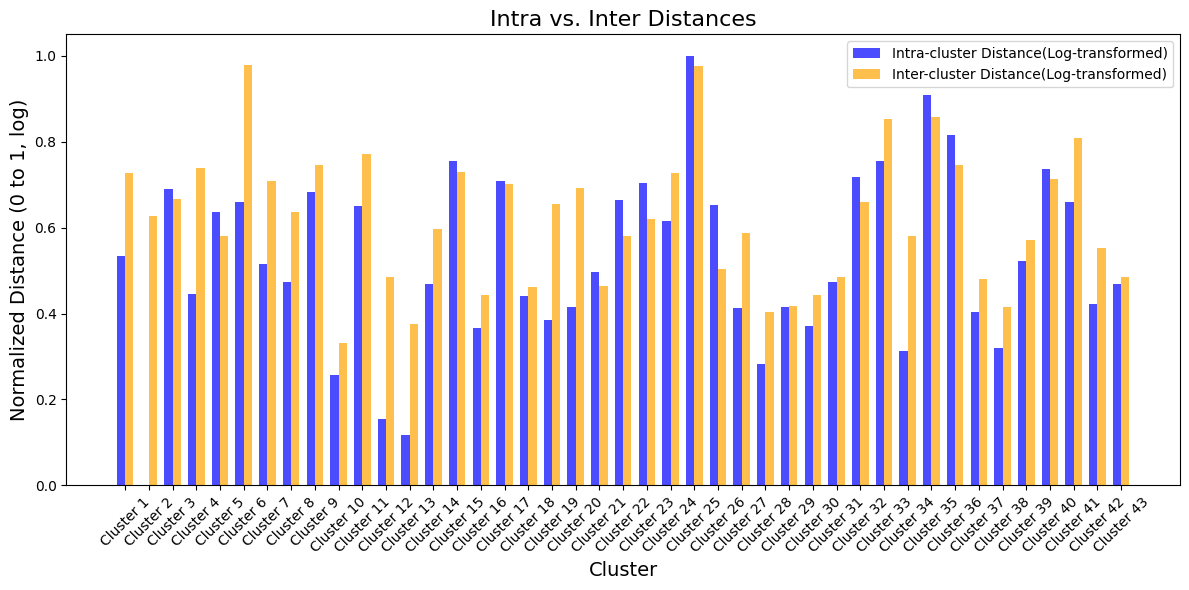

In [29]:
pca_space = pd.read_csv('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/pca_0.99.csv')
medoid_indices = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/medoid/medoid_indices_500.npy')
cluster_sampling_indices = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/medoid/cluster_sampling_indices_500.npy')
n_samples = 100

intra_cluster_distances, inter_cluster_distances = calculate_distances(pca_space.to_numpy(), medoid_indices, cluster_sampling_indices, n_samples)
# plot_cluster_distances(intra_cluster_distances, inter_cluster_distances)
# log_transform_and_plot(intra_cluster_distances, inter_cluster_distances)
plot_normalized_cluster_distances(intra_cluster_distances, inter_cluster_distances)
log_transform_and_normalize_and_plot(intra_cluster_distances, inter_cluster_distances)

##### proportion and kde analysis

In [5]:
umapspace = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/umap/umap_space_40_0.1_eu.npy')
cluster_labels = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf/soft_labels_leaf_500.npy')

results = analyze_cluster_differences(umapspace, cluster_labels, kde_threshold=0.0001)

for cluster_id, cluster_result in results.items():
    print(f"Cluster {cluster_id}:")
    print(f"  Proportion Analysis: {cluster_result['proportion_analysis']}")
    print(f"  KDE Analysis: {cluster_result['kde_analysis']}")
    print(f"  Counts: {cluster_result['counts']}")

# Save the result
import json

file_path = None
file_path = ''
if file_path is not None:
    with open(file_path, 'w') as f:
            json.dump(results, f, indent=4)

Cluster 0:
  Proportion Analysis: {'group_0_rate': 0.008970279195436805, 'group_1_rate': 0.010843590513359352, 'z_stat': -6.685058996183783, 'p_value': 2.308316326244189e-11}
  KDE Analysis: {'wasserstein_distance': 0.00012738989617084543, 'ks_stat': 0.0015, 'ks_p': 1.0}
  Counts: {'group_0_count': 2241, 'group_1_count': 2709}
Cluster 1:
  Proportion Analysis: {'group_0_rate': 0.024032822976083258, 'group_1_rate': 0.00702892024417092, 'z_stat': 48.60182714895852, 'p_value': 0.0}
  KDE Analysis: {'wasserstein_distance': 0.00020755235176697466, 'ks_stat': 0.0075, 'ks_p': 0.9411994973047206}
  Counts: {'group_0_count': 6004, 'group_1_count': 1756}
Cluster 2:
  Proportion Analysis: {'group_0_rate': 0.012692885019513659, 'group_1_rate': 0.004030821575102572, 'z_stat': 33.61990067938653, 'p_value': 8.588721730505262e-248}
  KDE Analysis: {'wasserstein_distance': 9.753669400259858e-05, 'ks_stat': 0.0037, 'ks_p': 0.9999998582247128}
  Counts: {'group_0_count': 3171, 'group_1_count': 1007}
Clus

FileNotFoundError: [Errno 2] No such file or directory: ''

##### spaef analysis

SPAEF: 0.4133
Pearson Corr: 0.4319
Spatial variability: 1.1237
Histogram: 0.9211
length:28877
SPAEF: 0.1064
Pearson Corr: 0.1346
Spatial variability: 1.1175
Histogram: 0.8104


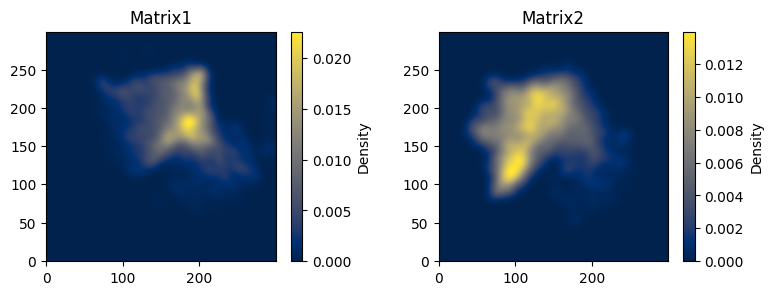

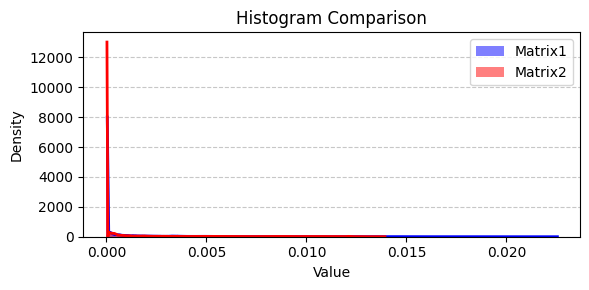

In [68]:
WTdensitymatrix = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf/WT5_density.npy')
ADdensitymatrix = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf/AD5_density.npy')
# scaled_WTmatrix = WTdensitymatrix / WTdensitymatrix.max()
# scaled_ADmatrix = ADdensitymatrix / ADdensitymatrix.max()
# print(f"Original matrix min: {WTdensitymatrix.min()}, max: {WTdensitymatrix.max()}")
# print(f"Scaled matrix min: {scaled_WTmatrix.min()}, max: {scaled_WTmatrix.max()}")

# SPAEF
spaef, alpha, beta, gamma = SPAEF(WTdensitymatrix, ADdensitymatrix)
spaef, alpha, beta, gamma = SPAEF_nonzero(WTdensitymatrix, ADdensitymatrix)
visualize_two_group(WTdensitymatrix,ADdensitymatrix)

# spaef, alpha, beta, gamma = SPAEF(scaled_WTmatrix, scaled_ADmatrix)
# spaef, alpha, beta, gamma = SPAEF_nonzero(scaled_WTmatrix, scaled_ADmatrix)
# visualize_two_group(scaled_WTmatrix, scaled_ADmatrix)

SPAEF: -0.1902
Pearson Corr: -0.0804
Spatial variability: 0.5583
Histogram: 0.7674
length:21619
SPAEF: -0.4882
Pearson Corr: -0.3993
Spatial variability: 0.6727
Histogram: 0.6134


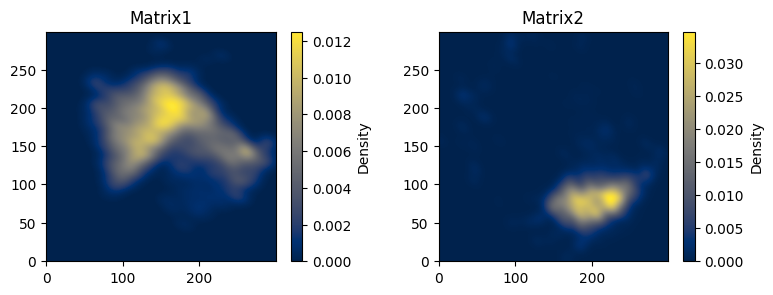

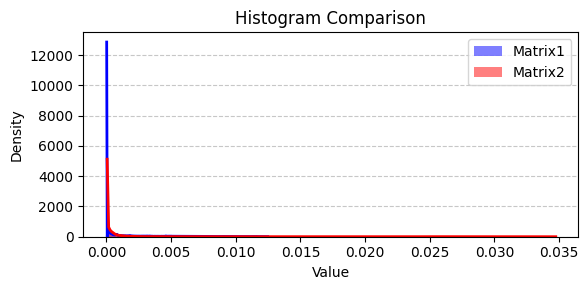

In [ ]:
WTdensitymatrix = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf/WT3_density.npy')
ADdensitymatrix = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf/AD3_density.npy')
# scaled_WTmatrix = WTdensitymatrix / WTdensitymatrix.max()
# scaled_ADmatrix = ADdensitymatrix / ADdensitymatrix.max()
# print(f"Original matrix min: {WTdensitymatrix.min()}, max: {WTdensitymatrix.max()}")
# print(f"Scaled matrix min: {scaled_WTmatrix.min()}, max: {scaled_WTmatrix.max()}")

# SPAEF
spaef, alpha, beta, gamma = SPAEF(WTdensitymatrix, ADdensitymatrix)
spaef, alpha, beta, gamma = SPAEF_nonzero(WTdensitymatrix, ADdensitymatrix)
visualize_two_group(WTdensitymatrix,ADdensitymatrix)

# spaef, alpha, beta, gamma = SPAEF(scaled_WTmatrix, scaled_ADmatrix)
# spaef, alpha, beta, gamma = SPAEF_nonzero(scaled_WTmatrix, scaled_ADmatrix)
# visualize_two_group(scaled_WTmatrix, scaled_ADmatrix)

SPAEF: 0.9221
Pearson Corr: 0.9489
Spatial variability: 0.9684
Histogram: 0.9503
length:38188
SPAEF: 0.8698
Pearson Corr: 0.9163
Spatial variability: 0.9606
Histogram: 0.9083


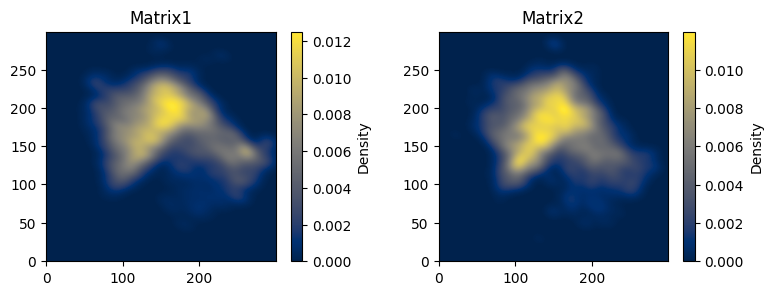

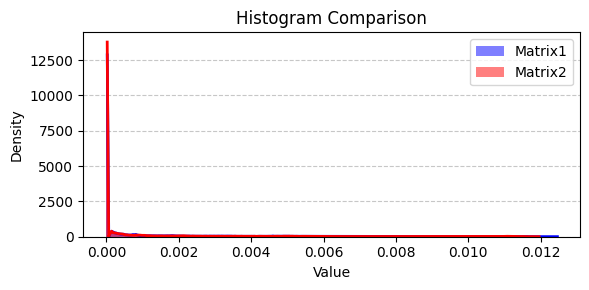

In [ ]:
WTdensitymatrix = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf/WT3_density.npy')
ADdensitymatrix = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf/AD1_density.npy')
# scaled_WTmatrix = WTdensitymatrix / WTdensitymatrix.max()
# scaled_ADmatrix = ADdensitymatrix / ADdensitymatrix.max()
# print(f"Original matrix min: {WTdensitymatrix.min()}, max: {WTdensitymatrix.max()}")
# print(f"Scaled matrix min: {scaled_WTmatrix.min()}, max: {scaled_WTmatrix.max()}")

# SPAEF
spaef, alpha, beta, gamma = SPAEF(WTdensitymatrix, ADdensitymatrix)
spaef, alpha, beta, gamma = SPAEF_nonzero(WTdensitymatrix, ADdensitymatrix)
visualize_two_group(WTdensitymatrix,ADdensitymatrix)

# spaef, alpha, beta, gamma = SPAEF(scaled_WTmatrix, scaled_ADmatrix)
# spaef, alpha, beta, gamma = SPAEF_nonzero(scaled_WTmatrix, scaled_ADmatrix)
# visualize_two_group(scaled_WTmatrix, scaled_ADmatrix)

##### SSIM(Structural Similarity Index)

In [10]:
ssim_value, _ = ssim(WTdensitymatrix, ADdensitymatrix, full=True,data_range=WTdensitymatrix.max() - WTdensitymatrix.min())
print(f"SSIM: {ssim_value}")

SSIM: 0.73587787991647
